# Count Data Tutorial

## 28th May 2014

### by Alan Saul, with edits by Neil Lawrence

In this tutorial we will look at using a Gaussian Process with a Poisson likelihood to model a response variable that is count data, i.e $ Y \in \mathbb{N}^{0} = \{0, 1, 2, 3, ..\}$.

This allows us to incorporate an approximate Poisson Process regression model into our Gaussian Process framework, indeed as the Poisson rate parameter, $\lambda$, becomes large the Poisson Process asymptotically approaches a Gaussian Process. This is important as if your counts are large, the rate, $\lambda$ at which events is happening is likely to be large, and it may not be required to use the approximation routine used here. Instead it may be more appropriate simply use a Gaussian Process, this will drastically reduce the computation required without a significant loss in accuracy.

The approximation we will use here is known as the Laplace approximation. The Laplace approximation was applied to Gaussian processes for classification by [Williams and Barber, 1999](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=735807&url=http%3A%2F%2Fieeexplore.ieee.org%2Fxpls%2Fabs_all.jsp%3Farnumber%3D735807). More details are given in [Rasmussen and Williams, 2006](http://www.gaussianprocess.org/gpml/),  Section 3.4 and Section 5.5.1. It has also been suggested for Gaussian random fields by [Rue, Martino and Chopin, 2009](http://hachamam-inla.googlecode.com/hg/r-inla.org/papers/inla-rss.pdf). The Laplace approximation is a local approximation. It proceeds by finding the mode of the posterior distribution and computing the curvature to find the fit.

First we perform some setup.

In [1]:
%pylab inline
import numpy as np
import scipy as sp
from scipy import stats
import pylab as pb

Populating the interactive namespace from numpy and matplotlib


Next we show the Poisson distribution for several different rate parameters.

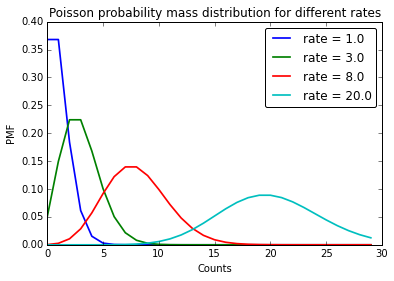

In [2]:
K = np.arange(0, 30, 1)[:, None]
rates = np.arange(0, 40, 1)[:, None]

#Make a matrix with PMF for (rate x count) combinations
rates_count = np.array([sp.stats.poisson(r).pmf(K) for r in rates]).reshape(rates.shape[0], K.shape[0])

rates_plot = [1,3,8,20]

#Plot each rate as a function of counts K
for r in rates_plot:
    pb.plot(K, rates_count[r, :], label='rate = {}'.format(float(rates[r])))

pb.title('Poisson probability mass distribution for different rates')
pb.ylabel('PMF')
pb.xlabel('Counts')
pb.legend()

As the rate increases, the Poisson distribution over discrete values begins to take on the form of a Gaussian density, over continuous values, as can be seen below.

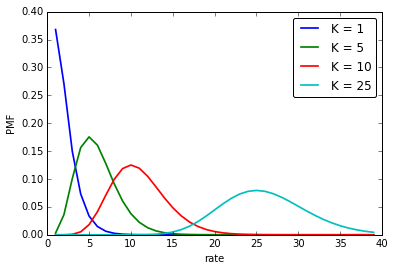

In [3]:
Ks = [1,5,10,25]
pb.figure()
for k in Ks:
    pb.plot(rates, rates_count[:, k], label='K = {}'.format(int(K[k])))

pb.xlabel('rate')
pb.ylabel('PMF')
pb.legend()

The variance of the Poisson distribution is equal to its mean. The Poisson only has support for non-negative integers, whereas a Gaussian has support over all real numbers (including negatives). This can complicate matters because if we place a Gaussian process prior directly over the rate of the Poisson, then the implication is that the rate can go negative. In practice we normally consider a Gaussian process over the logarithm of the rate. This is known as a log Gaussian process. It is formed by combining a logarithmic link function with a Gaussian model. 

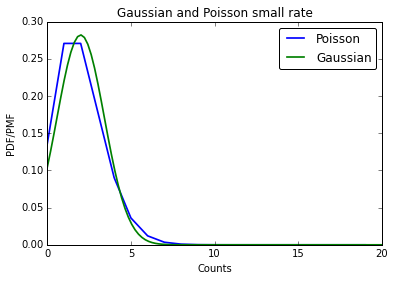

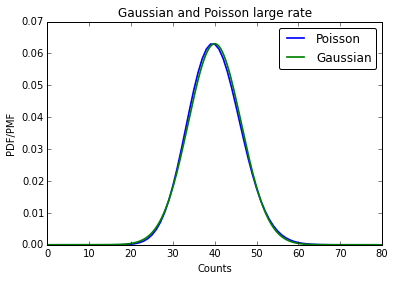

In [4]:
small_rate = 2
K = np.arange(0, 20, 1)[:, None]
Kcont = np.linspace(0, 20, 100)[:, None]
gauss20 = sp.stats.norm(loc=small_rate, scale=np.sqrt(small_rate)).pdf(Kcont)
poisson20 = sp.stats.poisson(small_rate).pmf(K)
pb.plot(K, poisson20, label='Poisson')
pb.plot(Kcont, gauss20, label='Gaussian')
pb.title('Gaussian and Poisson small rate')
pb.ylabel('PDF/PMF')
pb.xlabel('Counts')
pb.legend()

pb.figure()
large_rate = 40
K = np.arange(0, 80, 1)[:, None]
Kcont = np.linspace(0, 80, 200)[:, None]
gauss40 = sp.stats.norm(loc=large_rate, scale=np.sqrt(large_rate)).pdf(Kcont)
poisson40 = sp.stats.poisson(large_rate).pmf(K)
pb.plot(K, poisson40, label='Poisson')
pb.plot(Kcont, gauss40, label='Gaussian')
pb.title('Gaussian and Poisson large rate')
pb.ylabel('PDF/PMF')
pb.xlabel('Counts')
pb.legend()

 /home/james/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1564: RuntimeWarning:divide by zero encountered in true_divide


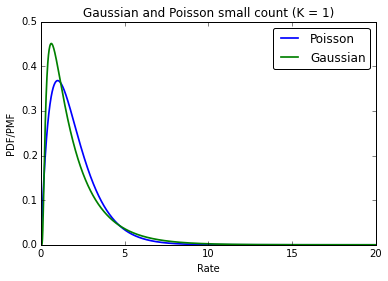

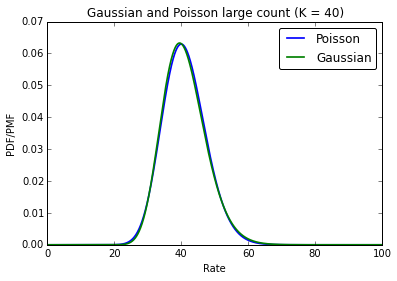

In [5]:
rates = np.arange(0, 20, 0.01)[:, None]
small_counts = 1
gauss3 = sp.stats.norm(loc=rates, scale=np.sqrt(rates)).pdf(small_counts)
#gauss3 = np.array([sp.stats.norm(loc=r, scale=np.sqrt(r)).pdf(small_counts) for r in rates])
poisson3 = sp.stats.poisson(rates).pmf(small_counts)
pb.plot(rates, poisson3, label='Poisson')
pb.plot(rates, gauss3, label='Gaussian')
pb.title('Gaussian and Poisson small count (K = {})'.format(small_counts))
pb.ylabel('PDF/PMF')
pb.xlabel('Rate')
pb.legend()

pb.figure()
rates = np.arange(0, 100, 0.01)[:, None]
large_counts = 40
gauss40 = sp.stats.norm(loc=rates, scale=np.sqrt(rates)).pdf(large_counts)
poisson40 = sp.stats.poisson(rates).pmf(large_counts)
pb.plot(rates, poisson40, label='Poisson')
pb.plot(rates, gauss40, label='Gaussian')
pb.title('Gaussian and Poisson large count (K = {})'.format(large_counts))
pb.ylabel('PDF/PMF')
pb.xlabel('Rate')
pb.legend()


If the counts are believed to follow a Poisson distribution and are very large, then the underlying rate is also likely to be large and we might reasonably approximate the Poisson likelihood with a Gaussian likelihood by matching the mean and variance to the observed counts. 

If, however, counts are relatively small, and we wish to fit Poisson process regression into a Gaussian Process framework, we may need a more involved approximation to the posterior.

The approximation used in this tutorial is called the Laplace approximation, it uses the location of the mode of the marginal distribution and the curvature of this mode (the hessian) to find a more appropriate Gaussian posterior approximation. As we shall see, in practice this is quite effective, and future tutorials will show us how it can be used to make Gaussian Process approximations to a range of different likelihoods, rather than just the Poisson, with relative ease.



Approximate Poisson Process Regression
======================================

Poisson process regression, contrasting to the above example, allows the rate to change, for example over time. That is the intensity of the counts can change, initially perhaps the data suggests there were few counts due to a low number of counts, but later this intensity is assumed to rise as we start observing larger more frequent counts. 

An example of data that might follow this change in 'intensity' is the times at which buses come throughout the day, we will choose this as our toy modelling example.

First we will generate some toy data, we will say that there are very few buses overnight, thus low counts, then during the morning rush-hour the number of observed counts rises, it then reduces and plateus until the evening rush-hour, and then finally as the evening draws on we observe again a reduced number 

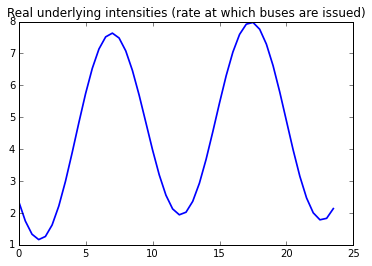

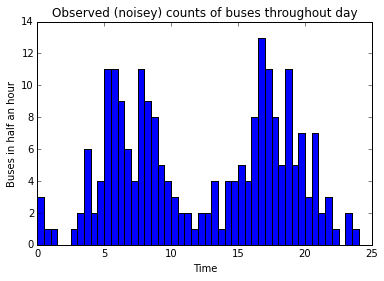

In [6]:
X = np.linspace(0,23.50,48)[:, None]
intensities = 4 + 3*np.sin(10 + 0.6*X) + np.sin(0.1*X)
pb.plot(X, intensities)
pb.title('Real underlying intensities (rate at which buses are issued)')

Y = np.array([[sp.random.poisson(intensity) for intensity in intensities]]).T
pb.figure()
pb.bar(X, Y, width=0.5)
pb.xlabel('Time')
pb.ylabel('Buses in half an hour')
pb.title('Observed (noisey) counts of buses throughout day')

We will now fit a Gaussian Process to this data using a Poisson likelihood and a Laplace approximation using GPy, as we shall see this is relatively simple, however to use Gaussian Processes we must make some assumptions about the intensity, we do this by defining a kernel.

In [7]:
import GPy
kernel = GPy.kern.RBF(1, variance=1.0, lengthscale=1.0)

By defining a radial basis function (RBF) kernel (also known as a exponentiated quadratic, squared exponential or Gaussian kernel), we are making *a priori* a smoothness assumption about the intensity parameter throughout time in this case. This is a very general assumption that is required in many learning algorithms, that data 'close' to one another shares similar properties. In this case we are saying that times that are close to one another have a similar number of buses arriving. 

The measure of closeness is defined by the lengthscale (or timescale) parameter, $\ell$, initially we set this to be 2.0, roughly speaking this says that as we have moved two time-steps (1 hour in this case) the intensity shares almost nothing with the intensity a hour previous.

The variance parameter describes our prior assumptions about the scale of the function being learnt. Both of these parameters although initialised here are usually optimized to find the most appropriate parameters, as such we set them to something that seems sensible but do not need to worry about having them absolutely correct.

There are a variety of likelihoods implemented in GPy, type 'GPy.likelihoods.' then press tab to list them.

There is also a number of alternative inference methods implemented, a subject for another tutorial, however it is worth noting that not all likelihoods are yet compatible with all inference methods. 

We now choose the type of likelihood and inference method we would like to use, in this case the Poisson likelihood and Laplace inference method. 

In [8]:
poisson_likelihood = GPy.likelihoods.Poisson()
laplace_inf = GPy.inference.latent_function_inference.Laplace()

Finally we are ready to create our model Gaussian Process model


Name                              : gp
Log-likelihood                    : -116.270631748
Number of Parameters              : 2
Number of Optimization Parameters : 2
Updates                           : True
Parameters:
  gp.              |  Value  |  Constraint  |  Prior  |  Tied to
  rbf.variance     |    1.0  |     +ve      |         |         
  rbf.lengthscale  |    1.0  |     +ve      |         |         


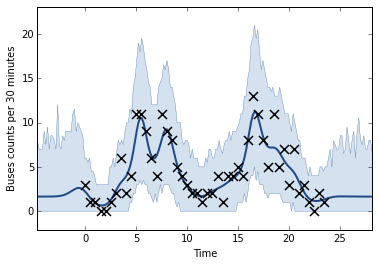

In [9]:
m = GPy.core.GP(X=X, Y=Y, likelihood=poisson_likelihood, inference_method=laplace_inf, kernel=kernel)
print m

#Predictions of counts of buses, including noise arising from Poisson noise
m.plot()
pb.xlabel('Time')
pb.ylabel('Buses counts per 30 minutes')

As we can see, the model as it stands is not all that great, the lengthscale parameter is soo small. We noted before that the kernels hyperparameters we chose were not the correct ones, only an initial guess. Next we try maximizing the likelihood of the model with respect to the parameters. Optimization within GPy is straightforward.


Name                              : gp
Log-likelihood                    : -107.662572418
Number of Parameters              : 2
Number of Optimization Parameters : 2
Updates                           : True
Parameters:
  gp.              |      Value      |  Constraint  |  Prior  |  Tied to
  rbf.variance     |  1.94142628259  |     +ve      |         |         
  rbf.lengthscale  |  3.85415837729  |     +ve      |         |         


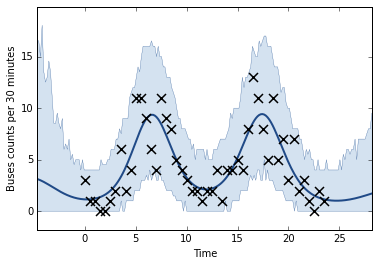

In [10]:
m.optimize('scg')
print m

#Predictions of counts of buses, including noise arising from Poisson noise
m.plot()
pb.xlabel('Time')
pb.ylabel('Buses counts per 30 minutes')

Now we should have a clearly better fit to the data, we have made predictions of the number of counts we would see throughout the day with our model and it seems to fit the training data we have provided quite well.

To get a better indication of the intensity we have infered we can plot the latent function $f$ of the model, this is the models prediction, before we have added Poisson noise to it. In fact the model is modelling the log intensity, this is what is displayed below

(-2, 3)

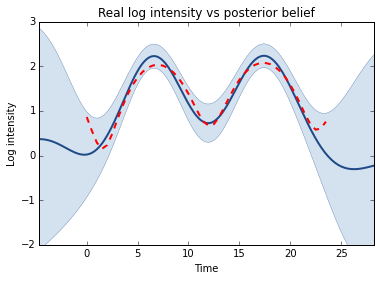

In [14]:
#Posterior distribution of the intensity of buses, and true intensity in red
m.plot_f()
pb.plot(X, np.log(intensities), '--r', linewidth=2)
pb.title('Real log intensity vs posterior belief')
pb.xlabel('Time')
pb.ylabel('Log intensity')
plt.ylim(-2,3)

To get the predictions from the model is straightforward with the plot functionality.

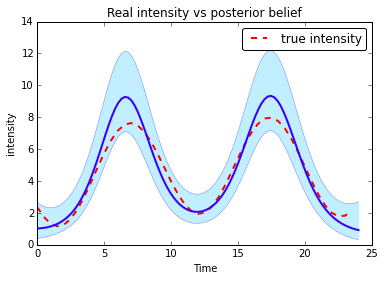

In [12]:
pred_points = np.linspace(0,24,100)[:, None]
#Predictive GP for log intensity mean and variance
f_mean, f_var = m._raw_predict(pred_points)
f_upper, f_lower = f_mean + 2*np.sqrt(f_var), f_mean - 2.*np.sqrt(f_var)
pb.plot(X, intensities, '--r', linewidth=2, label='true intensity')
#Plotting Y on an exponential scale as we are now looking at intensity rather than log intensity
GPy.plotting.matplot_dep.base_plots.gpplot(pred_points, np.exp(f_mean), np.exp(f_lower), np.exp(f_upper), ax=pb.gca())
pb.title('Real intensity vs posterior belief')
pb.xlabel('Time')
pb.ylabel('intensity')
pb.legend()